## 1. Setup & Preprocessing
## Problem Statement

Depression is one of the most prevalent mental health issues worldwide, significantly affecting daily life and well-being. Wearable and smartphone-based sensing provides an opportunity to passively capture behavioral signals such as physical activity, sleep, and mobility. The objective of this study is to analyze longitudinal behavioral data from the **GLOBEM dataset** to understand the relationship between these signals and depression symptoms.

---

## Research Questions
1. Can daily step count and sleep duration patterns help identify signs of depression?
2. Do weekday vs. weekend behavioral patterns differ for individuals with higher depression scores?
3. How accurately can a machine learning model classify depression status using passive sensing features?

---

## Dataset Reference
- **Source:** [The GLOBEM dataset](https://the-globem.github.io)
- **Description:** Collected over four consecutive years (2018–2021) from 497 individuals (~705 person-years).
- **Features:** Step count, sleep duration, and other passive behavioral metrics.
- **Labels:** Weekly depression survey scores (binary outcome: depressed / not depressed).


In [1744]:
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import pandas as pd

In [1745]:
#Data Path
DATA_DIR = '/Volumes/SanDisk/MyData/WALSHAIMl/WalshAIML/Capstone/Depression-Detection/globem-dataset-multi-year-datasets-for-longitudinal-human-behavior-modeling-generalization-1.1/Data/'
DATA_SETS = ['INS-W_1','INS-W_2','INS-W_3','INS-W_4']

In [1746]:
#Load features and depression scores
data_yearly = {}
for dataset in DATA_SETS:
    features = pd.read_csv(DATA_DIR+ dataset + '/FeatureData/rapids.csv', low_memory=False)
    labels = pd.read_csv(DATA_DIR+ dataset + '/SurveyData/dep_weekly.csv')
    data_yearly[dataset] = pd.merge(features, labels[['pid', 'date', 'dep']], on=['pid', 'date'], how='inner')

In [1747]:
step_col = 'f_steps:fitbit_steps_summary_rapids_avgsumsteps:allday'
sleep_duration_col = 'f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:allday'

In [1748]:
user_yearly = {'INS-W_1':'INS-W_004',
               'INS-W_2':'INS-W_302',
               'INS-W_3':'INS-W_603',
               'INS-W_4':'INS-W_1003',
               }
#user_yearly = {'INS-W':'INS-W_004',
#               'INS-W':'INS-W_302',
#               'INS-W':'INS-W_603',
#               'INS-W':'INS-W_1003',
#               }
#DATA_SETS = ['INS-W']

In [1749]:
pd.set_option('future.no_silent_downcasting', True)
for dataset, df in data_yearly.items():
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    threshold = 0.2  # 20% valid data required
    valid_ratio = df.notna().mean()  # fraction of non-NaN values per column
    columns_to_keep = valid_ratio[valid_ratio >= threshold].index
    df_clean = df[columns_to_keep].copy()
    df_clean['date'] = df_clean['date'].astype(str).str.strip()
    df_clean['date'] = pd.to_datetime(df_clean['date'],errors='coerce').astype('datetime64[ns]')
    data_yearly[dataset] = df_clean


## Exploratory Data Analysis (EDA)

In [1750]:
# Exploratory Data Analysis (EDA)
for dataset, df in data_yearly.items():
    print(f"\nDataset: {dataset}")
    print(df.info())

    # Missing values
    print("\nMissing values:")
    print(df.isna().sum().head())
    print("*************************************")


Dataset: INS-W_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360 entries, 0 to 2359
Columns: 3727 entries, Unnamed: 0 to dep
dtypes: bool(1), datetime64[ns](1), float64(2482), int64(1), object(1242)
memory usage: 67.1+ MB
None

Missing values:
Unnamed: 0                                                                0
pid                                                                       0
date                                                                      0
f_slp:fitbit_sleep_summary_rapids_sumdurationafterwakeupmain:14dhist    407
f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:14dhist         407
dtype: int64
*************************************

Dataset: INS-W_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Columns: 3973 entries, Unnamed: 0 to dep
dtypes: bool(1), datetime64[ns](1), float64(2646), int64(1), object(1324)
memory usage: 68.4+ MB
None

Missing values:
Unnamed: 0                                                       

In [1751]:
def line_plot_steps_summary(data_yearly, user_yearly):
    fig, ax = plt.subplots(2,2,figsize=(14,8))
    ax = ax.flatten()
    for i,dataset in enumerate(DATA_SETS[:4]):
        data = data_yearly[dataset]
        steps_df = data[['pid','date',step_col,'dep']].copy()
        # Ensure proper datetime format
        steps_df['date'] = pd.to_datetime(steps_df['date'])
        user_id = user_yearly[dataset]
        steps_df_user = steps_df[steps_df['pid'] == user_id]
        ax[i].plot(steps_df_user['date'], steps_df_user[step_col], marker='o', linestyle='-', label='Daily Steps')
        # If depression scores are available, overlay them
        if 'dep' in steps_df_user.columns:
            depressed_days = steps_df_user[steps_df_user['dep'] == True]  # threshold example
            ax[i].scatter(depressed_days['date'], depressed_days[step_col],
                    color='red', label='Depression', zorder=5, marker='x',s=100)
        # Set labels and title
        ax[i].set_xlabel("Date")
        ax[i].set_ylabel("Step Count")
        ax[i].set_title(f"Daily Step Count Over Time - User {user_id}")
        ax[i].tick_params(axis='x', rotation=45)
        # Show legend and grid
        ax[i].legend()
        ax[i].grid(True)
    plt.tight_layout()
    plt.show()


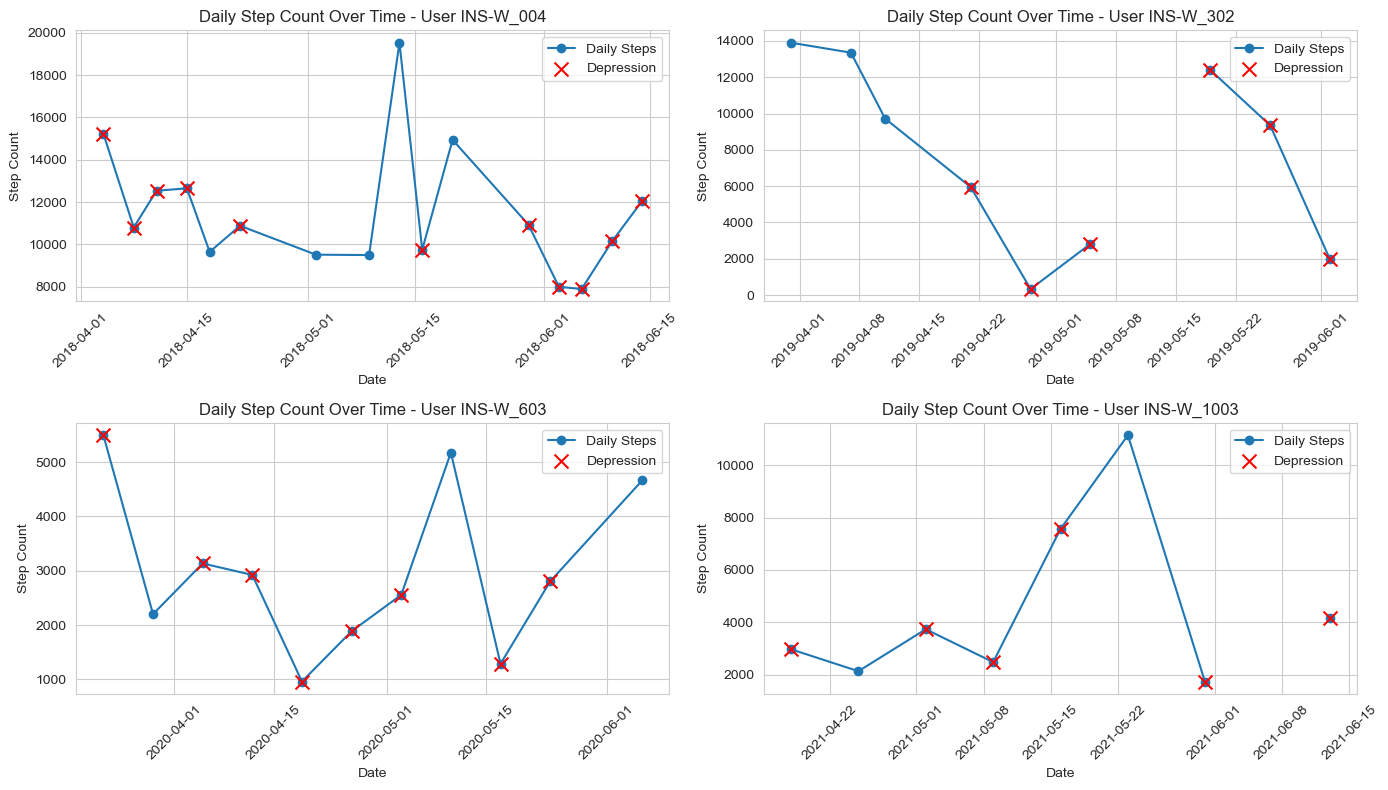

In [1752]:
line_plot_steps_summary(data_yearly,user_yearly)

In [1753]:
def box_plot_distrution_weekdays_weekend(data_yearly):
    fig, ax = plt.subplots(2,2,figsize=(14,8))
    ax = ax.flatten()
    for i,dataset in enumerate(DATA_SETS[:4]):
        data = data_yearly[dataset]
        sleep_df = data[['date',sleep_duration_col]].copy()
        # Ensure proper datetime format
        sleep_df['date'] = pd.to_datetime(sleep_df['date'])
        # Extract day of week (0=Monday ... 6=Sunday)
        sleep_df['day_of_week'] = sleep_df['date'].dt.dayofweek
        # Create weekday/weekend flag
        sleep_df['day_type'] = sleep_df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
        # Select only the needed columns
        sleep_duration_df = sleep_df[[sleep_duration_col, 'day_type']].dropna()
                # Prepare data for boxplot
        grouped = [
            sleep_duration_df.loc[sleep_duration_df['day_type'] == "Weekday", sleep_duration_col],
            sleep_duration_df.loc[sleep_duration_df['day_type'] == "Weekend", sleep_duration_col]
        ]
        ax[i].boxplot(grouped,tick_labels=["Weekday", "Weekend"],vert=True,
                      patch_artist=True)
        ax[i].set_title(f"Sleep Duration: Weekday vs Weekend - {dataset}")
        ax[i].set_ylabel("Sleep Duration (minutes)")
        ax[i].set_xlabel("Day Type")
        ax[i].grid(True)
    plt.tight_layout()
    plt.show()

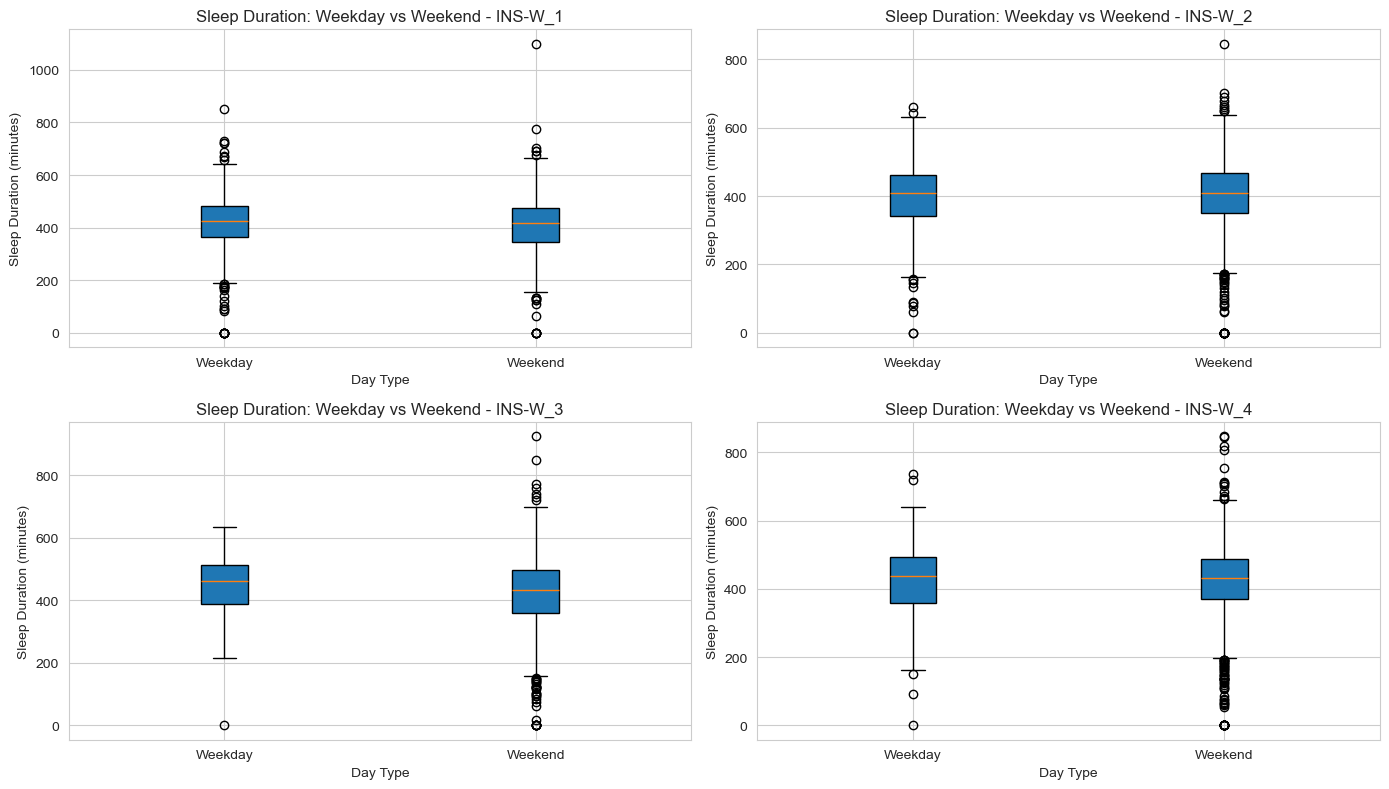

In [1754]:
box_plot_distrution_weekdays_weekend(data_yearly)

In [1755]:
# Example: Outlier detection on sleep duration
for dataset, df in data_yearly.items():
    q1 = df[sleep_duration_col].quantile(0.25)
    q2 = df[sleep_duration_col].quantile(0.50)
    q3 = df[sleep_duration_col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[sleep_duration_col] < lower) | (df[sleep_duration_col] > upper)]
    print(f"{dataset}: Sleep duration: Q1 {round(q1,2)}, Q2 {round(q2,2)}, Q3 {round(q3,2)} Outliers {len(outliers)}")

INS-W_1: Sleep duration: Q1 355.0, Q2 421.0, Q3 479.0 Outliers 43
INS-W_2: Sleep duration: Q1 348.75, Q2 410.0, Q3 464.25 Outliers 68
INS-W_3: Sleep duration: Q1 361.25, Q2 436.0, Q3 498.0 Outliers 39
INS-W_4: Sleep duration: Q1 367.5, Q2 432.0, Q3 487.0 Outliers 73


In [1756]:
def remove_outliers_iqr(df, cols):
    """Remove outliers from specified columns using IQR method."""
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        # Remove outliers
        df[col] = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

In [1757]:
# Pick relevant behavioral + depression columns
features = ['f_steps:fitbit_steps_summary_rapids_avgsumsteps:allday',
            'f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:allday',
            'f_screen:phone_screen_rapids_avgdurationunlock:allday',
            'f_call:phone_calls_rapids_outgoing_meanduration:allday',
            'f_call:phone_calls_rapids_incoming_meanduration:allday',
            'dep']

featuresdict = {
    features[0]:'dailysteps',
    features[1]:'sleep',
    features[2]:'screentime',
    features[3]:'outgoingcalltime',
    features[4]:'incomingcalltime',
    features[5]:'depression',
}

In [1758]:
features_data_yearly = {}
for i,dataset in enumerate(DATA_SETS[:4]):
    data = data_yearly[dataset]
    features_df = data[features].dropna(how='all')
    features_df = features_df.rename(columns=featuresdict)
    features_data_yearly[dataset] = features_df

In [1759]:
def draw_heat_map_behavioral_features(features_data_yearly):
    fig, ax = plt.subplots(2,2,figsize=(14,10))
    ax = ax.flatten()
    for i,dataset in enumerate(DATA_SETS[:4]):
        features_df = features_data_yearly[dataset]
        # Compute correlation matrix
        corr_matrix = features_df.corr(method='pearson')
        sns.heatmap(corr_matrix,ax=ax[i] ,annot=True, cmap="YlGnBu", fmt='.2f')
        ax[i].set_title(f"Correlation Matrix:Behavioral Features over depression - {dataset}")
        ax[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

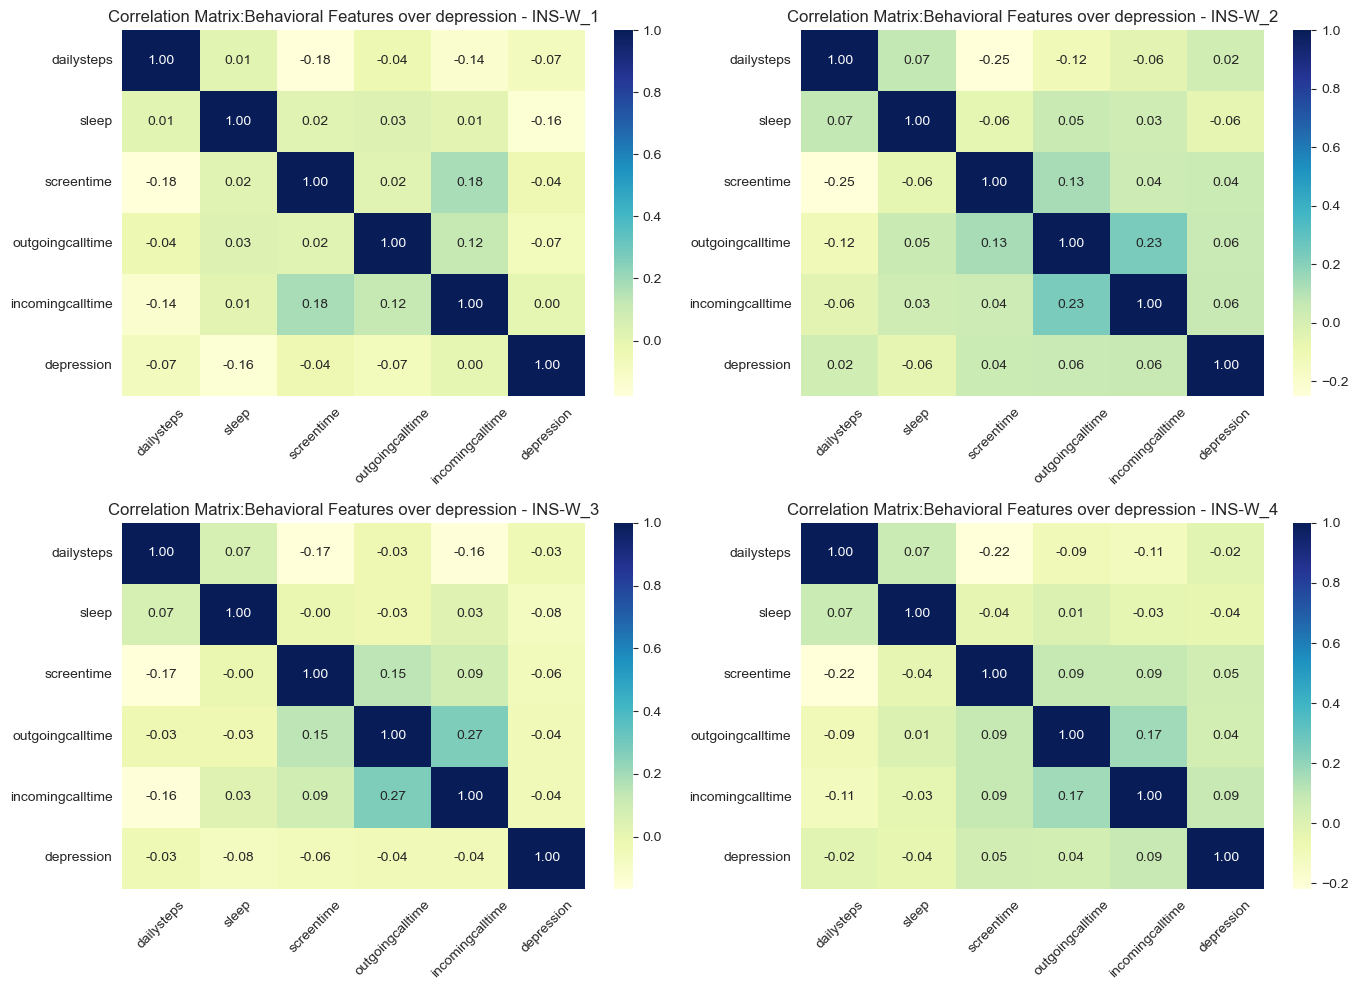

In [1760]:
draw_heat_map_behavioral_features(features_data_yearly)

In [1761]:
def draw_histogram_behavioral_features(features_data_yearly):
    fig, ax = plt.subplots(10,2,figsize=(12,20))
    ax = ax.flatten()
    index = 0
    for i,dataset in enumerate(DATA_SETS[:4]):
        features_df = features_data_yearly[dataset]
        values_list = list(featuresdict.values())
        X_labels = features_df[values_list[:-1]]
        y_label = values_list[-1]
        for feature in X_labels:
            sns.histplot(features_df,x=feature, ax=ax[index], bins=30,hue=y_label, kde=True, palette='viridis')
            ax[index].set_title(f"Distribution of {feature} - {dataset}")
            ax[index].grid(True)
            ax[index].set_ylabel("Frequency")
            ax[index].set_xlabel(feature)
            index += 1
    plt.tight_layout()
    plt.show()

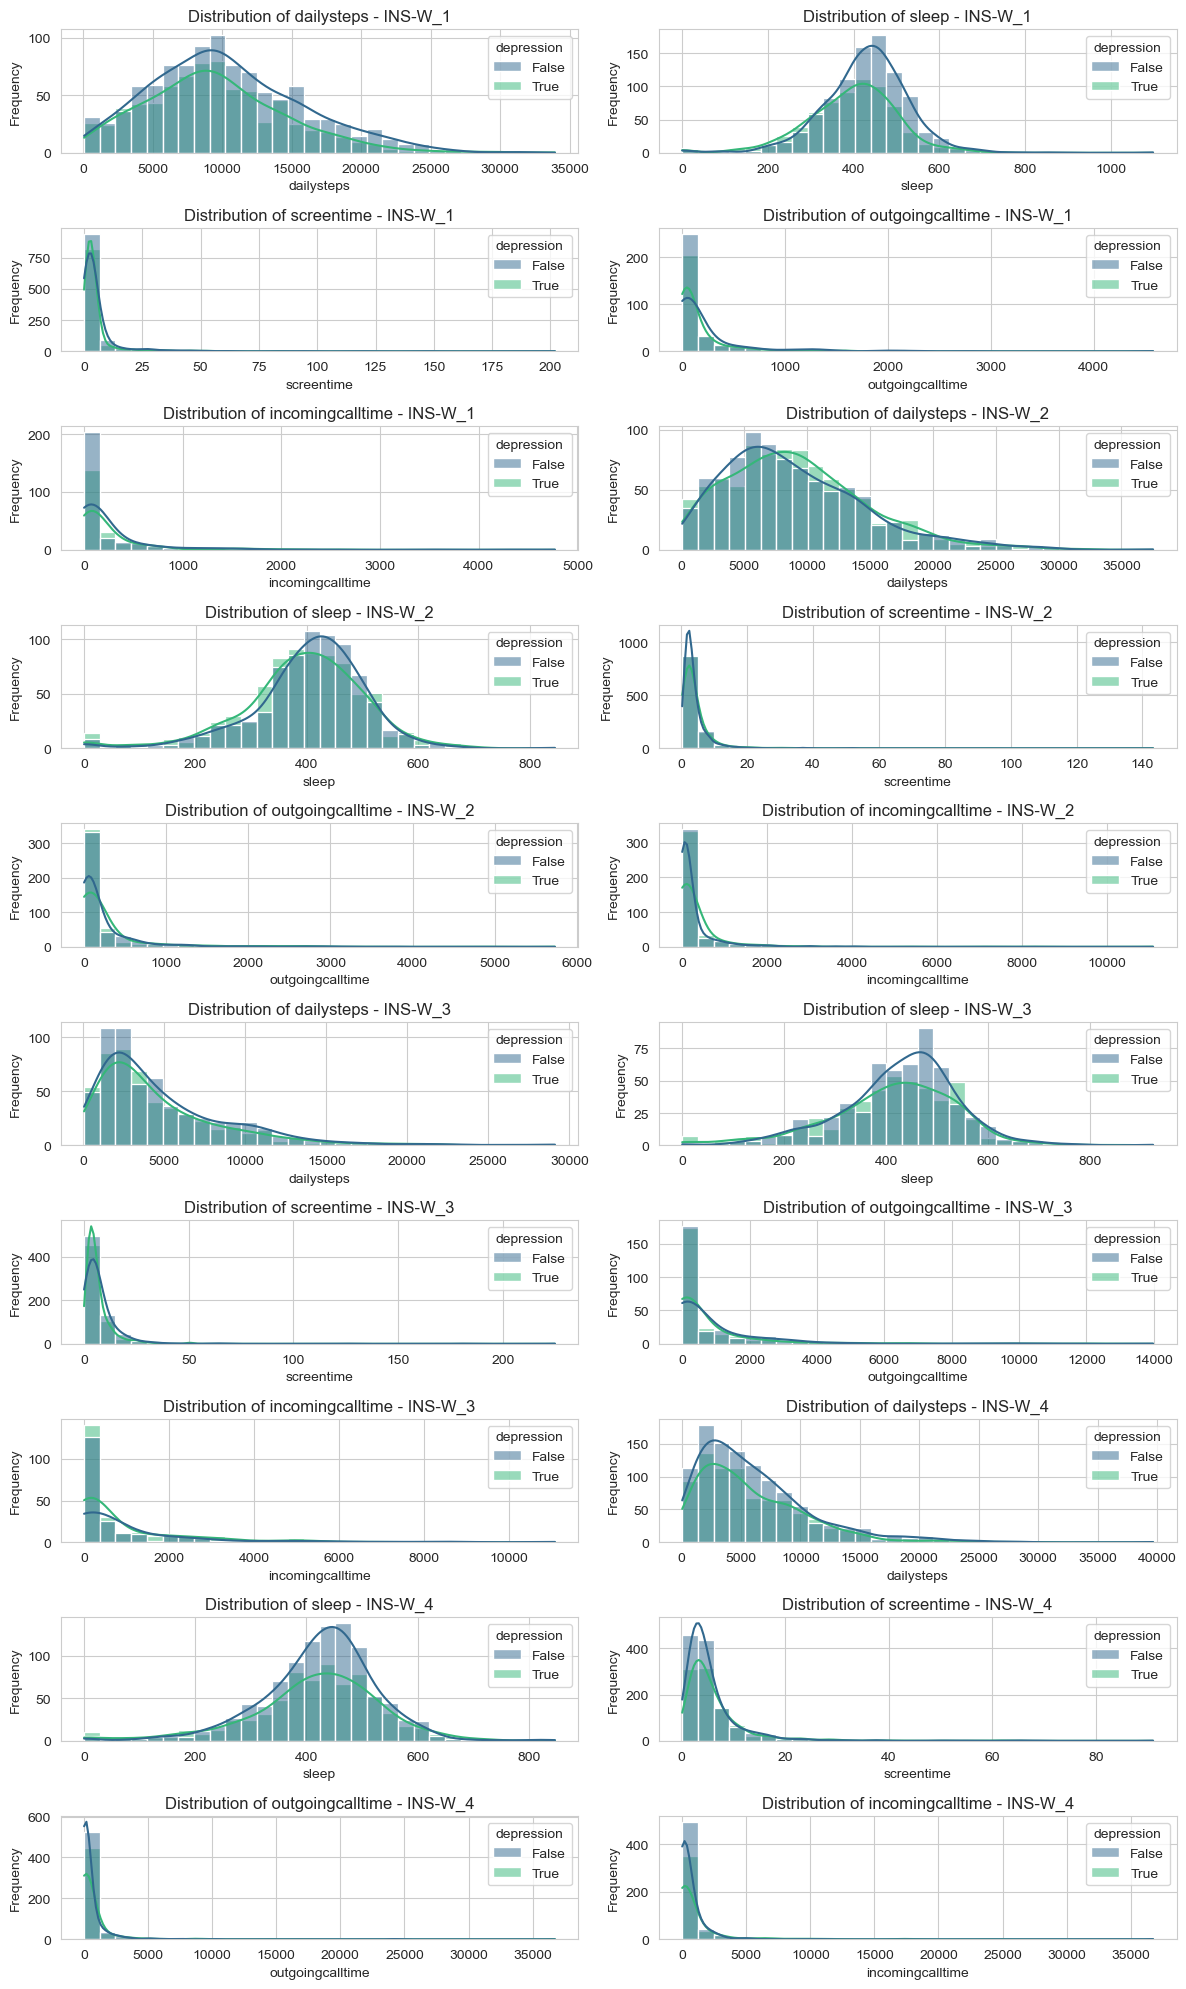

In [1762]:
draw_histogram_behavioral_features(features_data_yearly)

In [1763]:
all_data = pd.DataFrame()
for i,dataset in enumerate(DATA_SETS[:4]):
       features_df = features_data_yearly[dataset]
       features_df['dataset'] = dataset
       all_data = pd.concat([all_data,features_df], ignore_index=True)
all_data = all_data.reset_index(drop=True)
summary = all_data.groupby(['dataset','depression']).describe()
summary = summary.round(2)
summary

dailysteps                                            \
                        count      mean      std   min      25%     50%   
dataset depression                                                        
INS-W_1 False          1015.0  10306.10  5476.58  56.0  6292.50  9635.0   
        True            747.0   9495.25  5168.48  63.0  5973.00  9055.0   
INS-W_2 False           876.0   8927.45  5678.20  60.0  4837.50  7915.0   
        True            885.0   9189.13  5568.69  51.0  5207.00  8612.0   
INS-W_3 False           597.0   4853.73  4232.06  64.0  1910.00  3431.0   
        True            511.0   4571.22  3845.35  53.0  1878.50  3384.0   
INS-W_4 False          1074.0   6025.29  4790.80  52.0  2499.25  4907.0   
        True            806.0   5811.00  4476.23  58.0  2369.25  4668.0   

                                       sleep          ... outgoingcalltime  \
                         75%      max  count    mean  ...              75%   
dataset depression                                    ...                    
INS-W_1 False       13701.00  31836.0  941.0  428.00  ...           168.25   
        True        12387.50  33947.0  676.0  394.83  ...           159.70   
INS-W_2 False       12214.00  37513.0  760.0  403.89  ...           200.00   
        True        12360.00  31743.0  756.0  390.54  ...           217.58   
INS-W_3 False        6516.00  29105.0  553.0  429.05  ...           979.50   
        True         6059.00  22018.0  457.0  410.53  ...           768.25   
INS-W_4 False        8130.75  39667.0  985.0  424.01  ...           408.08   
        True         8385.50  29579.0  714.0  415.53  ...           384.94   

                             incomingcalltime                                \
                         max            count     mean      std  min    25%   
dataset depression                                                            
INS-W_1 False        4576.00            276.0   244.00   533.62  0.0  33.91   
        True         2129.00            212.0   247.40   410.73  0.0  34.29   
INS-W_2 False        3688.00            400.0   245.72   483.37  0.0  35.00   
        True         5734.00            411.0   331.73   900.58  0.0  40.91   
INS-W_3 False       13977.50            216.0  1005.06  1855.24  0.0  47.00   
        True        11855.08            246.0   868.79  1349.50  4.0  41.12   
INS-W_4 False       24123.00            568.0   611.62  1826.77  0.0  41.00   
        True        36743.00            431.0   978.29  2455.31  2.0  47.83   

                                               
                       50%      75%       max  
dataset depression                             
INS-W_1 False        68.00   201.60   4772.00  
        True         90.50   272.56   2620.00  
INS-W_2 False        66.50   214.92   4020.00  
        True         90.50   228.48  11078.46  
INS-W_3 False       213.00  1031.77  11088.00  
        True        207.75  1150.50   7223.33  
INS-W_4 False       155.46   652.50  36744.00  
        True        163.25   792.00  23897.73  

[8 rows x 40 columns]

In [1764]:
def features_importance_yearly(features_data_yearly):
    fig, ax = plt.subplots(2,2,figsize=(12,6))
    ax = ax.flatten()
    index = 0
    for i,dataset in enumerate(DATA_SETS[:4]):
        features_df = features_data_yearly[dataset]
        # Assuming your DataFrame is named df
        # Separate features and target
        values_list = list(featuresdict.values())
        X = features_df[values_list[:-1]]
        y_label = values_list[-1]
        y = features_df[y_label]
        # Optional: scale features for better performance
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        # Split into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        # Train Random Forest
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        # Get feature importances
        importances = model.feature_importances_
        feature_names = X.columns
        # Create a DataFrame for easy viewing
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        # Plot
        sns.barplot(x='Importance', y='Feature', data=importance_df,ax=ax[index],color='blue')
        ax[index].set_title(f"Feature Importance for Depression Prediction of - {dataset}")
        ax[index].set_ylabel("Feature", fontsize=10)
        ax[index].set_xlabel('Importance Score', fontsize=10)
        index += 1
    plt.tight_layout()
    plt.show()

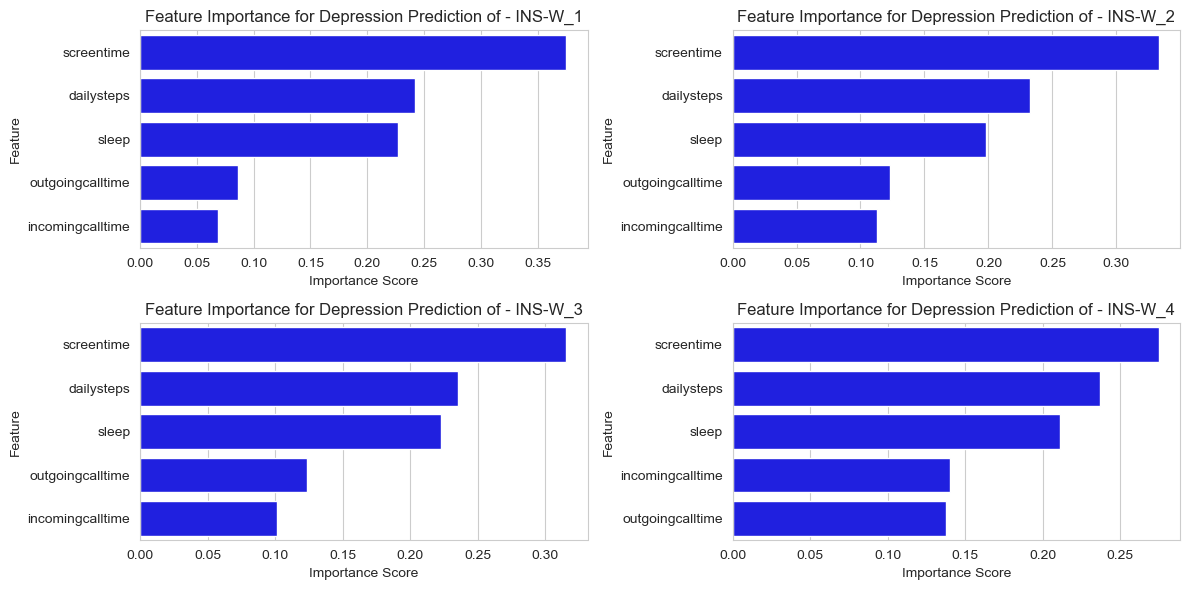

In [1765]:
features_importance_yearly(features_data_yearly)

## Step 2: Normalize Features (Per User)

User-level normalization is the process of transforming each user’s time-series data relative to their own historical baseline, not the entire dataset.

#### Motivation:
- Different users have different natural behaviors.
- One person might sleep 9 hours, another 6 hours — both are normal for them.
- Applying global normalization would treat this variance as noise.
- Goal: Detect deviations from personal norms, not population norms.

In [1766]:
def normalize_per_user(df, user_col='pid', feature_cols=[]):
    norm_cols = {}
    for col in feature_cols:
        col_norm = df.groupby(user_col)[col].transform(
            lambda x: (x - x.median()) / (x.quantile(0.95) - x.quantile(0.05) + 1e-6)
        )
        norm_cols[col + '_norm'] = col_norm
    # Create a single new DataFrame and concatenate
    norm_df = pd.DataFrame(norm_cols)
    df = pd.concat([df.reset_index(drop=True), norm_df], axis=1)
    return df

In [1767]:
def get_feature_columns(data):
    # Parse features to normalize (excluding discretized or already normalized)
    feature_cols = [col for col in data.columns if ':' in col
                    and '_norm' not in col
                    and '_dis' not in col
                    and '14dhist' not in col
                    and '7dhist' not in col]
    return feature_cols

In [1768]:
def get_normalize_features_columns(feature_cols=[]):
    norm_feature_cols = [f + '_norm' for f in feature_cols]
    return norm_feature_cols

A rolling window is a technique where you take overlapping fixed-size segments from a time-series to analyze local temporal patterns.

We are working with daily passive behavioral data for each user. Instead of modeling entire time-series as a whole:
- Extract small chunks (e.g., 7 days at a time)
- Move the window forward day-by-day (or by custom steps)
- Label each window with a mood score (e.g., PHQ-4) on the last day

In [1769]:
WINDOW_SIZE=7
def create_rolling_windows(df, user_col='pid', window_size=WINDOW_SIZE, step_size=1, feature_cols=None, label_col='dep'):
    X, y, users,weekend   = [], [], [],[]
    for pid, group in df.groupby(user_col):
        group = group.sort_values('date')
        if len(group) < window_size:
            continue
        for start in range(0, len(group) - window_size + 1, step_size):
            window = group.iloc[start:start+window_size]
            if window[label_col].isnull().any():
                continue
            X.append(window[feature_cols].values)
            y.append(window[label_col].iloc[-1])
            isWeekEnd = window['date'].apply(lambda x: 1 if pd.to_datetime(x).dayofweek >= 5 else 0).iloc[-1]
            weekend.append(isWeekEnd)
            users.append(pid)
    return np.array(X), np.array(y), np.array(users),np.array(weekend)

In [1770]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
def applyLabelEncoder(df):
    obj_cols = df.select_dtypes(include='object')
    for col in obj_cols.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(obj_cols[col].astype(str))
    return df

def remove_NAN_INF(df):
    df_clean = df.replace([np.inf, -np.inf], np.nan)  # replace Inf
    df_clean = df_clean.fillna(0)                     # replace NaN with 0
    return df_clean

def apply_normalization(df,skip_cols=['pid']):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    result = [item for item in numeric_cols if item not in skip_cols]
    df[result] = MinMaxScaler().fit_transform(df[result])
    return df


In [1771]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
def getImportantFeatures(df,xColumns,yColumn='dep',top_k=150):
    X = df[xColumns]
    y = df[yColumn]
    if y.dtypes == "object":
        y = LabelEncoder().fit_transform(y)

    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X, y)
    # Get importance scores
    importances = pd.Series(rf.feature_importances_, index=X.columns)
    top100 = importances.nlargest(top_k).index.tolist()
    return top100

In [1772]:
rolling_windows_yearly = {}
def create_rolling_windows_yearly(data_yearly):
    for i,dataset in enumerate(DATA_SETS[:4]):
        start = time.time()
        data = data_yearly[dataset]
        features_column = get_feature_columns(data)
        data = remove_NAN_INF(data)
        data = applyLabelEncoder(data)
        data = apply_normalization(data)

        df = normalize_per_user(data, user_col='pid', feature_cols=features_column)
        normalized_column = get_normalize_features_columns(features_column)
        normalized_column = getImportantFeatures(df, normalized_column)
         # Normalize
        X, y, users,weekend = create_rolling_windows(df, feature_cols = normalized_column)
        dict = {}
        dict['X'] = X
        dict['Y'] = y
        dict['users'] = users
        dict['weekend'] = weekend
        rolling_windows_yearly[dataset] = dict
        print(f'Rolling windows for dataset of {dataset}: {len(df)} X= {X.shape} y= {y.shape} users={users.shape} time={round(time.time() - start,2)} seconds')

## Step 3: Hierarchical Temporal Contrastive Learning (HTCL)
**Hierarchical Temporal Contrastive Learning (HTCL)** is a deep learning framework designed to learn robust and personalized representations of sequential (temporal) data — particularly for behavioral modeling tasks like depression detection from smartphone-based passive sensing.

Hierarchical Temporal Contrastive Learning is a learning paradigm that uses contrastive loss at multiple temporal resolutions (hierarchies) to train models to differentiate between:
- Semantically similar sequences (e.g., the same user under similar mental states) and
- Semantically different sequences (e.g., different users or opposite mental states),
<br>
in order to learn temporally-aware, user-sensitive embeddings for downstream tasks like classification or regression.

**Key Concepts** <br>
1. Contrastive Learning
- Learns by comparing triplets: (anchor, positive, negative)
- Goal: bring anchor ↔ positive closer in latent space, and push anchor ↔ negative further apart
- Used without explicit supervision (e.g., PHQ scores may not be needed during representation learning)
2. Temporal
- Input data is sequential, e.g., 7-day behavior windows
- Patterns like sleep, activity, and phone usage evolve over time
- Model learns from temporal dependencies
3. Hierarchical
Learns from multiple temporal levels:
- Short-term windows: daily or weekly patterns
- Long-term context: across months or individuals
- Contrastive objectives are applied at different levels:
    - Intra-user contrast: different time windows of the same user
    - Inter-user contrast: compare across different users



In [1773]:
# Rolling windows
create_rolling_windows_yearly(data_yearly)

Rolling windows for dataset of INS-W_1: 2360 X= (1444, 7, 150) y= (1444,) users=(1444,) time=33.54 seconds
Rolling windows for dataset of INS-W_2: 2256 X= (966, 7, 150) y= (966,) users=(966,) time=50.81 seconds
Rolling windows for dataset of INS-W_3: 1360 X= (548, 7, 150) y= (548,) users=(548,) time=27.58 seconds
Rolling windows for dataset of INS-W_4: 2174 X= (1013, 7, 150) y= (1013,) users=(1013,) time=41.99 seconds


 The Transformer Encoder is a neural network architecture designed to handle sequential data, like: <br>
- Time-series (e.g., 7-day windows of behavior)
- Text (as in NLP)
- Sensor readings over time (as in your GLOBEM dataset)
<br>
###
Originally introduced in the "Attention is All You Need" paper (Vaswani et al., 2017), the Transformer replaces traditional RNNs (like LSTMs) with attention mechanisms, which are faster, more parallelizable, and better at modeling long-term dependencies.

| **Need**  | 	**Transformer Role**                         |
|-----------|-----------------------------------------------|
|Capture patterns over 7-day behavior windows | 	Attends to every day in the window           |
|Weigh importance of different days' behavior | 	Self-attention dynamically scores time steps |
|Model complex dependencies between signals	| Learns how sleep, activity, phone use relate  |
|Handle variable temporal relevance	| Not all days contribute equally to label      |

In the context of depression detection from time-series data:
| **Component**          | **Function**                                                                 |
|------------------------|------------------------------------------------------------------------------|
| Input Sequence         | A 7-day window of normalized behavioral features per user                    |
| Input dim            | `(batch_size, 7, input_dim)`                                                 |
| Linear Embedding       | Projects raw input features into a higher-dimensional latent space           |
| Positional Encoding    | Adds day-wise order info to each time step (since Transformers are orderless)|
| Multi-Head Attention   | Learns dependencies between all days in the sequence                         |
| Feed-Forward Layer     | Applies nonlinear transformation to each time step                           |
| Encoder Layer Stack    | Multiple layers of attention + feed-forward blocks                           |
| Output Sequence        | Contextualized representation of each day in the window                      |
| Output Shape           | `(batch_size, 7, model_dim)`                                                 |
| Usage in Model         | Final day’s output (e.g., `x[:, -1, :]`) is passed to classification layers  |


The Triplet Loss is central to your temporal contrastive learning approach.
It's used to learn better representations by enforcing that: <br>

**“Samples from the same user and mood state are closer together than samples from different users or mood states.”**

Triplet Loss compares:
- Anchor: a sample (e.g., a 7-day window)
- Positive: a sample similar to anchor (same user or same label)
- Negative: a dissimilar sample (different user or opposite label)

| **Term**       | **Meaning**                                                                 |
|----------------|------------------------------------------------------------------------------|
| Anchor         | Input window to be learned                                                  |
| Positive       | Similar window (same user/label)                                            |
| Negative       | Dissimilar window (different user or label)                                 |
| Distance       | Cosine or Euclidean (usually cosine in behavior models)                     |
| Margin         | Minimum gap enforced between positive and negative pairs (e.g., 0.2)        |
| Loss Goal      | Push anchor closer to positive, farther from negative                       |
| Use Case       | Self-supervised representation learning for personalized behavior modeling  |



The ContextDecoder is a neural module that transforms contextual metadata (e.g., "is weekend", "is during COVID", etc.) into a vector representation that can be fused with the behavior sequence encoding.
**Human behavior is context-dependent — the same sleep pattern on a Monday vs. Saturday may mean different things.**

|**Component**|**Meaning**|
|--------|---------|
|Input	| A vector like [0, 1, 1] → weekend, COVID, holiday|
|Output	| A latent vector like [0.3, -0.5, 1.2, ...] |
| Role	| Provides context-aware information to the model |

The PersonalizedAdapter is a learnable transformation layer designed to personalize the model’s behavior to individual users. <br>

In depression detection: <br>
Each person has different baselines and behavioral patterns. <br>
A model trained globally might miss subtle personal signals. <br>
The PersonalizedAdapter helps tune the shared model’s outputs to better fit an individual user. <br>

Why It Helps in Depression Detection

|**Problem**|**Adapter Solution**|
|-------|--------|
|One model can't fit all users|	Learns user-specific representation shift|
|Subtle differences ignored|	Emphasizes deviations based on personal patterns|
|Context alone is not enough|	Personal embedding + context improves generalization|


In [1774]:
#This is a parameterized neural module that learns a transformation of the input representation — it's essentially a bottleneck projection + expansion, applied identically to all samples.
#This design is commonly called a "bottleneck adapter" — it's popular in NLP models (like BERT adapters) and meta-learning setups.
#It is helpful in
## Keeps parameter count low
## Allows quick adaptation with few gradients
## Prevents overfitting by acting like a regularized attention shift

import torch
import torch.nn as nn
class PersonalizedAdapter(nn.Module):
    def __init__(self, num_users, hidden_dim, adapter_dim=128):
        super(PersonalizedAdapter, self).__init__()

        # User embeddings
        self.user_embedding = nn.Embedding(num_users, adapter_dim)
        self.alpha = nn.Parameter(torch.tensor(0.5))  # learnable weight
        # Bottleneck adapter
        self.down = nn.Linear(hidden_dim, adapter_dim)
        self.up = nn.Linear(adapter_dim, hidden_dim)

    def forward(self, x, user_ids):
        # User embedding
        user_emb = self.user_embedding(user_ids)  # (batch_size, adapter_dim)
        # Apply adapter transformation
        z = self.down(x) + user_emb               # inject personalization
        z = torch.relu(z)
        out = self.up(z) * self.alpha + x         # residual connection

        return out


This is a simple linear classifier that takes a feature vector (e.g., from your Transformer + context + adapter) and outputs logits for binary classification — predicting:
- Class 0: Non-depressed
- Class 1: Depressed

### Full Pipeline
- Sequence of user behavior → encoded via Transformer
- Context + personalization → added via adapters
- Resulting vector → fed to this DepressionClassifier
- Outputs logits → passed to loss or softmax

In [1775]:
import torch.nn as nn

class DepressionDetectionModel(nn.Module):
    def __init__(self, input_dim, context_dim,num_users,hidden_dim=128, num_layers=2, dropout=0.4, num_classes=2):
        super(DepressionDetectionModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim,
                          num_layers=num_layers,
                          batch_first=True,
                          dropout=dropout if num_layers > 1 else 0,
                          bidirectional=True)

        self.context_embedding = nn.Embedding(context_dim, hidden_dim)
        # Personalized Adapter
        self.adapter = PersonalizedAdapter(num_users=num_users, hidden_dim=hidden_dim*2, adapter_dim=32)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*2+hidden_dim, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, context_ids,user_ids):
        out,h = self.gru(x)
        seq_repr = out[:, -1, :]
        # Apply personalization
        #seq_repr = self.adapter(seq_repr, user_ids)
        ctx_repr = self.context_embedding(context_ids)
        combined_repr = torch.cat([seq_repr, ctx_repr], dim=1)
        combined = self.dropout(combined_repr)
        logits = self.fc(combined)
        return logits

This is a standard PyTorch training function that:

- Takes a model, dataloader, optimizer, and number of epochs
- Runs forward and backward passes
- Updates weights using classification loss
- Tracks and prints the average loss per epoch

In [1776]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader ,criterion,num_epochs=20, lr=1e-3, weight_decay=5e-4):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_state = None
    patience = 5
    for epoch in range(num_epochs):
        # ------------------
        # Training phase
        # ------------------
        model.train()
        train_losses, train_preds, train_labels = [], [], []
        for xb, yb, context_ids,user_ids  in train_loader:
            xb, yb, context_ids,user_ids = xb.to(device), yb.to(device), context_ids.to(device), user_ids.to(device)
            optimizer.zero_grad()
            logits = model(xb,context_ids,user_ids)  # assumes model returns (B, num_classes)
            loss = criterion(logits, yb)
            loss.backward()
            # Clip gradients to prevent exploding
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_losses.append(loss.item())
            train_preds.extend(logits.argmax(dim=1).cpu().numpy())
            train_labels.extend(yb.cpu().numpy())

        train_f1 = f1_score(train_labels, train_preds, average='weighted',zero_division=0)
        # ------------------
        # Validation phase
        # ------------------
        model.eval()
        val_losses, val_preds, val_labels = [], [], []
        with torch.no_grad():
            for xb, yb,context_ids,user_ids in val_loader:
                xb, yb, context_ids,user_ids = xb.to(device), yb.to(device), context_ids.to(device), user_ids.to(device)
                logits = model(xb,context_ids,user_ids)  # assumes model returns (B, num_classes)
                loss = criterion(logits, yb)
                val_losses.append(loss.item())
                val_preds.extend(logits.argmax(dim=1).cpu().numpy())
                val_labels.extend(yb.cpu().numpy())

        val_f1 = f1_score(val_labels, val_preds,average='weighted', zero_division=0)
        val_loss = sum(val_losses)/len(val_losses)
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {sum(train_losses)/len(train_losses):.4f}, Train f1: {train_f1:.2f} | "
              f"Val Loss: {sum(val_losses)/len(val_losses):.4f}, Val f1: {val_f1:.2f}")


        # ---------------- EARLY STOPPING ----------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pt')  # save best model
        else:
            epochs_no_improve += 1
            best_state = model.state_dict()
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break

    # Load best weights
    if best_state:
        model.load_state_dict(best_state)
    return model

Using device: cpu


In [1777]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def getDataLoaders(users, X,y,weekend, batch_size=64,test_size=0.2, val_size=0.1,seed = 23):
    unique_users = np.unique(users)
    train_users, test_users = train_test_split(unique_users, test_size=test_size, random_state=seed)
    train_users, val_users  = train_test_split(train_users, test_size=val_size, random_state=seed)
    val_users = test_users
    # Masks for indexing
    train_mask = np.isin(users, train_users)
    val_mask   = np.isin(users, val_users)
    test_mask  = np.isin(users, test_users)

    # Split tensors
    X_train, y_train,weekend_train,train_users = X[train_mask], y[train_mask],weekend[train_mask],users[train_mask]
    X_val, y_val, weekend_val,val_users = X[val_mask], y[val_mask], weekend[val_mask], users[val_mask]
    X_test, y_test, weekend_test,test_users = X[test_mask], y[test_mask],weekend[test_mask], users[test_mask]

    # Convert to torch tensors
    X_train, y_train,weekend_train,train_users = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long), torch.tensor(weekend_train, dtype=torch.long),torch.tensor(train_users, dtype=torch.long)
    X_val, y_val,weekend_val,val_users = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long), torch.tensor(weekend_val, dtype=torch.long), torch.tensor(val_users, dtype=torch.long)
    X_test, y_test,weekend_test,test_users = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long),torch.tensor(weekend_test, dtype=torch.long),torch.tensor(test_users, dtype=torch.long)

    print(f"Train DataSet =X_train.shape {X_train.shape},y_train.shape= {y_train.shape},weekend_train.shape= {weekend_train.shape},train_users.shape {train_users.shape}")
    print(f"Val DataSet =X_val.shape {X_val.shape},y_val.shape= {y_val.shape},weekend_val.shape= {weekend_val.shape}, val_users.shape {val_users.shape}")
    print(f"Test DataSet =X_train.shape {X_test.shape},y_train.shape= {y_test.shape},weekend_train.shape= {weekend_test.shape}, test_users.shape {test_users.shape}")

    # Wrap in TensorDataset
    train_ds = TensorDataset(X_train, y_train, weekend_train,train_users)
    val_ds   = TensorDataset(X_val, y_val,  weekend_val,val_users)
    test_ds  = TensorDataset(X_test, y_test, weekend_test,test_users)

    # 5. Dataloaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

In [1778]:
from sklearn.utils.class_weight import compute_class_weight
model_data_yearly = {}
for dataset, rolling_windows in rolling_windows_yearly.items():
    X = rolling_windows['X']
    Y = rolling_windows['Y']
    print(f"X shape = {X.shape},Y.shape= {Y.shape}")

    weekend = rolling_windows['weekend']
    users = rolling_windows['users']
    class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    train_loader, val_loader, test_loader = getDataLoaders(users,X,Y,weekend)

    print(f'***** Starting training for dataset {dataset} *****')

    model = DepressionDetectionModel(
        input_dim=X.shape[2],                 # number of normalized features per day
        context_dim=2,                        # number of context tokens (e.g., weekend, COVID, etc.)
        num_users=max(users)+1,
        num_classes=2)

    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    model = train_model(model, train_loader,val_loader,criterion,num_epochs=50)
    dict = {}
    dict['model'] = model
    dict['train_loader'] = train_loader
    dict['test_loader'] = test_loader
    dict['val_loader'] = val_loader
    model_data_yearly[dataset] = dict

X shape = (1444, 7, 150),Y.shape= (1444,)
Train DataSet =X_train.shape torch.Size([1037, 7, 150]),y_train.shape= torch.Size([1037]),weekend_train.shape= torch.Size([1037]),train_users.shape torch.Size([1037])
Val DataSet =X_val.shape torch.Size([292, 7, 150]),y_val.shape= torch.Size([292]),weekend_val.shape= torch.Size([292]), val_users.shape torch.Size([292])
Test DataSet =X_train.shape torch.Size([292, 7, 150]),y_train.shape= torch.Size([292]),weekend_train.shape= torch.Size([292]), test_users.shape torch.Size([292])
***** Starting training for dataset INS-W_1 *****
Epoch 1/50 | Train Loss: 0.7424, Train f1: 0.49 | Val Loss: 0.6947, Val f1: 0.53
Epoch 2/50 | Train Loss: 0.6789, Train f1: 0.57 | Val Loss: 0.6962, Val f1: 0.55
Epoch 3/50 | Train Loss: 0.6043, Train f1: 0.67 | Val Loss: 0.7824, Val f1: 0.57
Epoch 4/50 | Train Loss: 0.5471, Train f1: 0.73 | Val Loss: 0.7906, Val f1: 0.53
Epoch 5/50 | Train Loss: 0.4892, Train f1: 0.76 | Val Loss: 0.8684, Val f1: 0.58
Epoch 6/50 | Train L

In [1779]:
from sklearn.metrics import accuracy_score, classification_report
def evaluate_model(model, test_loader,criterion):
    model.eval()
    model.to(device)
    all_preds,all_probs, all_labels = [], [],[]
    test_loss = 0.0
    with torch.no_grad():
        for xb, yb, context_ids,user_ids in test_loader:
            xb, yb,context_ids,user_ids = xb.to(device), yb.to(device),context_ids.to(device),user_ids.to(device)
            logits = model(xb,context_ids,user_ids)  # (B, num_classes)
            # Get predictions
            probs = torch.softmax(logits, dim=1)  # (B, num_classes)
            preds = torch.argmax(probs, dim=1)
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(yb.cpu().numpy())
    return all_preds,all_probs, all_labels

In [1780]:
test_results = {}
for dataset, data_tensor in model_data_yearly.items():
    model = data_tensor['model']
    test_loader = data_tensor['test_loader']
    preds_labels,prob_labels, true_labels = evaluate_model(model, test_loader,criterion)
    dict = {}
    dict['dataset'] = dataset
    dict['preds_labels'] = preds_labels
    dict['prob_labels'] = prob_labels
    dict['true_labels'] = true_labels
    test_results[dataset] = dict

In [1781]:
from sklearn.metrics import balanced_accuracy_score

report_data = []
for dataset, test_result in test_results.items():
    print(f"Classification Report for {dataset}")
    true_labels = test_result['true_labels']
    preds_labels = test_result['preds_labels']
    print(classification_report(true_labels, preds_labels,zero_division=0))
    print("******************************************")
    dict = {}
    dict['dataset'] = dataset
    dict['balanced_accuracy'] = balanced_accuracy_score(true_labels, preds_labels)
    dict['precision'] = precision_score(true_labels, preds_labels,average='weighted',zero_division=0)
    dict['recall'] = recall_score(true_labels, preds_labels,average='weighted',zero_division=0)
    dict['f1'] = f1_score(true_labels, preds_labels,average='weighted',zero_division=0)
    report_data.append(dict)

Classification Report for INS-W_1
              precision    recall  f1-score   support

           0       0.51      0.75      0.61       138
           1       0.62      0.36      0.46       154

    accuracy                           0.55       292
   macro avg       0.57      0.56      0.54       292
weighted avg       0.57      0.55      0.53       292

******************************************
Classification Report for INS-W_2
              precision    recall  f1-score   support

           0       0.51      0.29      0.37       109
           1       0.45      0.67      0.54        94

    accuracy                           0.47       203
   macro avg       0.48      0.48      0.46       203
weighted avg       0.48      0.47      0.45       203

******************************************
Classification Report for INS-W_3
              precision    recall  f1-score   support

           0       0.58      0.67      0.62        57
           1       0.60      0.51      0.55      

In [1782]:
report_df = pd.DataFrame(report_data)
report_df

,dataset,balanced_accuracy,precision,recall,f1
0,INS-W_1,0.558630,0.571479,0.547945,0.531206
1,INS-W_2,0.481895,0.481109,0.467980,0.449131
2,INS-W_3,0.587879,0.590081,0.589286,0.586645
3,INS-W_4,0.579633,0.592077,0.582915,0.585736


In [1783]:
def draw_confusion_matrix():
    fig, ax = plt.subplots(2,2,figsize=(12,8))
    ax = ax.flatten()
    index = 0
    for dataset, test_result in test_results.items():
        true_labels = test_result['true_labels']
        preds_labels = test_result['preds_labels']
        cm = confusion_matrix(true_labels, preds_labels)
        sns.heatmap(cm,ax=ax[index], annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Depressed', 'Depressed'],
        yticklabels=['Non-Depressed', 'Depressed'])
        ax[index].set_title(f"Confusion matrix of - {dataset}")
        ax[index].set_ylabel("True Label", fontsize=10)
        ax[index].set_xlabel('Predicted Label', fontsize=10)
        index += 1
    plt.tight_layout()
    plt.show()

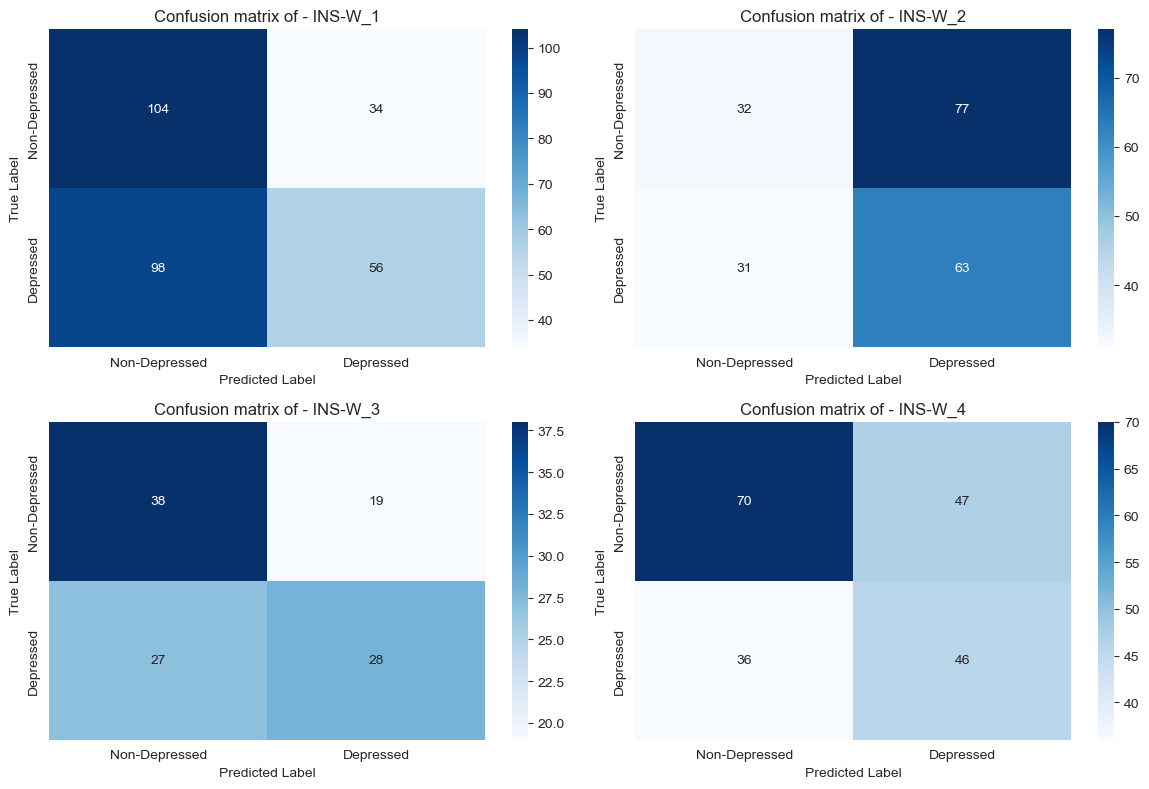

In [1784]:
draw_confusion_matrix()

In [1785]:
def draw_roc_auc_plot():
    fig, ax = plt.subplots(2,2,figsize=(12,8))
    ax = ax.flatten()
    index = 0
    for dataset, test_result in test_results.items():
        true_labels = np.array(test_result['true_labels'])
        prob_labels = np.array(test_result['prob_labels'])[:, 1]  # probability for class 1 (Depressed)
        fpr, tpr, thresholds = roc_curve(true_labels, prob_labels)
        roc_auc = auc(fpr, tpr)
        ax[index].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        ax[index].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax[index].set_xlabel('False Positive Rate', fontsize=10)
        ax[index].set_ylabel('True Positive Rate', fontsize=10)
        ax[index].set_title(f'Receiver Operating Characteristic-{dataset}')
        ax[index].legend(loc="lower right")
        index += 1
    plt.tight_layout()
    plt.show()

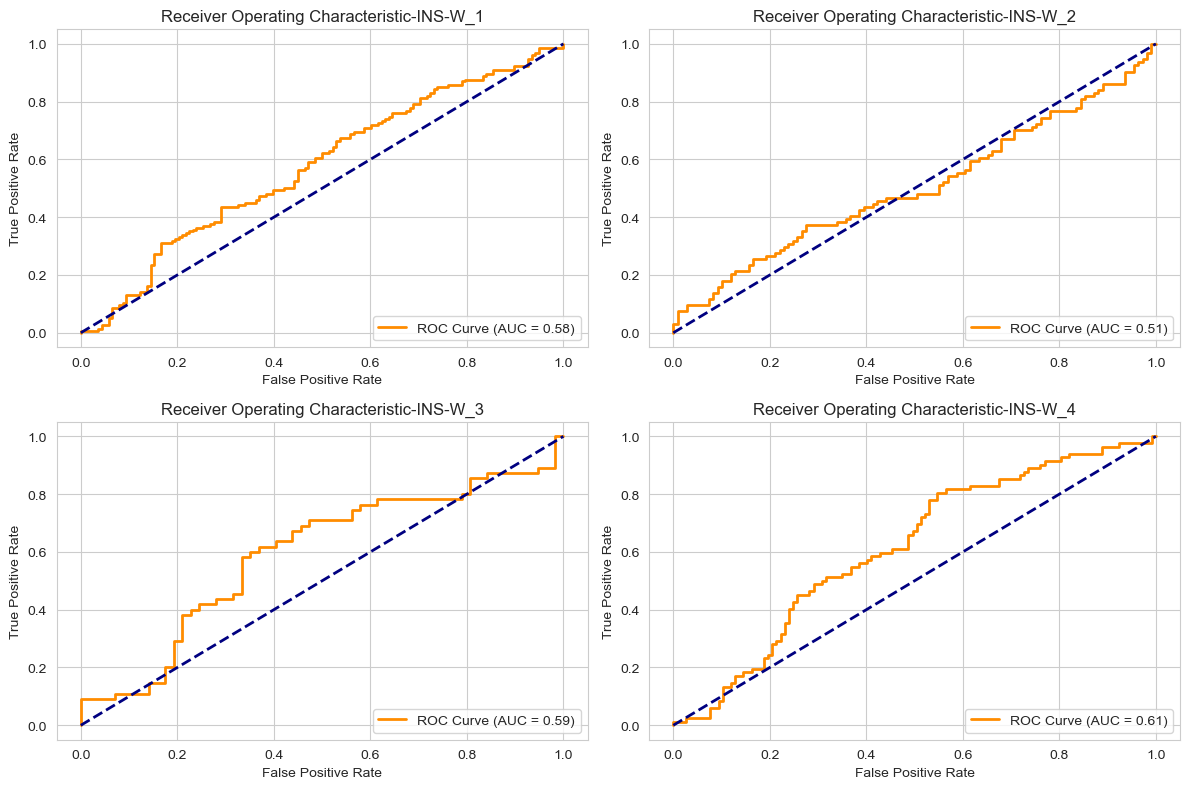

In [1786]:
draw_roc_auc_plot()